#### Carga librerias

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime
import scipy.sparse as sp
from sklearn.metrics.pairwise import cosine_similarity
import random
from scipy.stats import pearsonr
from collections import Counter
import collections

#### Carga archivo

In [43]:
df = pd.read_csv("./Video_Games.csv", header=None)

df.columns = ['item_id', 'user_id', 'rating', 'timestamp']

df = df.drop('timestamp', axis=1)

print(f"Tamaño total del dataset: {df.shape}")

Tamaño total del dataset: (2565349, 3)


In [44]:
top_n_users = 100000 # Maximo de usuarios con los que queremos trabajar
min_ratings = 10   # Usuarios con al menos este número de ratings
user_counts = df['user_id'].value_counts()

dense_users = user_counts[user_counts >= min_ratings].index.tolist()

if len(dense_users) > top_n_users:
    dense_users = dense_users[:top_n_users]

print(f"Seleccionados {len(dense_users)} usuarios con al menos {min_ratings} ratings cada uno")

df_dense = df[df['user_id'].isin(dense_users)]

print(f"Tamaño del dataset filtrado: {df_dense.shape}")
print(f"Reducción del dataset: {100 * (1 - len(df_dense) / len(df)):.2f}%")

Seleccionados 15517 usuarios con al menos 10 ratings cada uno
Tamaño del dataset filtrado: (284867, 3)
Reducción del dataset: 88.90%


In [45]:
def random_split(data, test_ratio=0.2, random_state=42):
    data_shuffled = data.sample(frac=1, random_state=random_state)
    
    split = int(len(data) * (1 - test_ratio))
    
    train = data_shuffled.iloc[:split]
    test = data_shuffled.iloc[split:]
    
    train_users = set(train['user_id'].unique())
    train_items = set(train['item_id'].unique())
    test = test[test['user_id'].isin(train_users) & test['item_id'].isin(train_items)]
    
    return train, test

train_data, test_data = random_split(df_dense)
print(f"Tamaño del conjunto de entrenamiento: {train_data.shape}")
print(f"Tamaño del conjunto de prueba: {test_data.shape}")

train_users = set(train_data['user_id'].unique())
train_items = set(train_data['item_id'].unique())
common_users = len(train_users.intersection(set(test_data['user_id'].unique())))
common_items = len(train_items.intersection(set(test_data['item_id'].unique())))

print(f"Usuarios comunes en train y test: {common_users}/{len(train_users)}")
print(f"Items comunes en train y test: {common_items}/{len(train_items)}")

Tamaño del conjunto de entrenamiento: (227893, 3)
Tamaño del conjunto de prueba: (53735, 3)
Usuarios comunes en train y test: 14541/15517
Items comunes en train y test: 15474/34132


#### Creación de matrices

Mapeos para los datos de entrenamiento

In [46]:
train_users_list = train_data['user_id'].unique()
train_items_list = train_data['item_id'].unique()

user2idx = {user_id: idx for idx, user_id in enumerate(train_users_list)}
item2idx = {item_id: idx for idx, item_id in enumerate(train_items_list)}

idx2user = {idx: user for user, idx in user2idx.items()}
idx2item = {idx: item for item, idx in item2idx.items()}

NUM_USERS = len(user2idx)
NUM_ITEMS = len(item2idx)
MIN_RATING = df['rating'].min()
MAX_RATING = df['rating'].max()

print(f"Usuarios: {NUM_USERS}, Items: {NUM_ITEMS}")

Usuarios: 15517, Items: 34132


Matriz de train sparse

In [47]:
# Inicializar matriz vacía
train_matrix = sp.lil_matrix((NUM_USERS, NUM_ITEMS))

# Llenar con valores sin acumular
for _, row in train_data.iterrows():
    if row['user_id'] in user2idx and row['item_id'] in item2idx:
        u_idx = user2idx[row['user_id']]
        i_idx = item2idx[row['item_id']]
        # Asignar directamente, sin acumular
        train_matrix[u_idx, i_idx] = row['rating']

# Convertir a CSR para operaciones eficientes
train_matrix = train_matrix.tocsr()

Matriz de test sparse

In [48]:
test_matrix = sp.lil_matrix((NUM_USERS, NUM_ITEMS))

# Llenar con valores sin acumular
for _, row in test_data.iterrows():
    if row['user_id'] in user2idx and row['item_id'] in item2idx:
        u_idx = user2idx[row['user_id']]
        i_idx = item2idx[row['item_id']]
        # Asignar directamente, sin acumular
        test_matrix[u_idx, i_idx] = row['rating']

# Convertir a CSR para operaciones eficientes
test_matrix = test_matrix.tocsr()

Medidas

In [49]:
print(f"Forma de la matriz de train: {train_matrix.shape}")
print(f"Densidad de la matriz de train: {train_matrix.nnz / (NUM_USERS * NUM_ITEMS):.6f}")
print(f"Forma de la matriz de test: {test_matrix.shape}")
print(f"Densidad de la matriz de test: {test_matrix.nnz / (NUM_USERS * NUM_ITEMS):.6f}")

Forma de la matriz de train: (15517, 34132)
Densidad de la matriz de train: 0.000416
Forma de la matriz de test: (15517, 34132)
Densidad de la matriz de test: 0.000101


# Matrix Factorization

In [50]:
import random
import numpy as np

# Hiperparámetros para Factorización Matricial
NUM_FACTORS = 10  # Número de factores latentes
LEARNING_RATE = 0.001  # Tasa de aprendizaje (gamma)
REGULARIZATION = 0.1  # Parámetro de regularización (lambda)
NUM_ITERATIONS = 10  # Número de iteraciones de entrenamiento

Inicializamos las matrices de factores con valores uniformes aleatorios en el intervalo \[0, 1].

In [51]:
def init_matrix_factorization_model():
    """Inicializa los parámetros del modelo de factorización matricial"""
    # Inicializar matriz de factores de usuario aleatoriamente
    p = np.random.random((NUM_USERS, NUM_FACTORS))
    
    # Inicializar matriz de factores de ítem aleatoriamente
    q = np.random.random((NUM_ITEMS, NUM_FACTORS))
    
    return p, q


Como hemos comentado, calcular la predicción del voto del usuario *u* al item *i* implicar realizar el producto escalar de sus vectores de factores. La siguiente función realiza esta operación:

In [52]:
def compute_prediction(p_u, q_i):
    """Calcula la predicción de valoración para un par usuario-ítem usando producto escalar"""
    return np.dot(p_u, q_i)



Implementemos la función de entrenamiento para el modelo PMF básico:



In [53]:
def train_pmf(train_matrix, num_iterations=NUM_ITERATIONS, learning_rate=LEARNING_RATE, 
            reg_param=REGULARIZATION, num_factors=NUM_FACTORS):
    """Entrena el modelo PMF usando descenso de gradiente"""
    # Inicializar parámetros del modelo
    p, q = init_matrix_factorization_model()
    
    print("Entrenando modelo PMF...")
    for it in range(num_iterations):
        print(f"Iteración {it+1}/{num_iterations}")
        
        # Procesar todas las valoraciones conocidas
        for u, i in zip(*train_matrix.nonzero()):
            # Obtener la valoración real
            r_ui = train_matrix[u, i]
            
            # Calcular predicción
            pred = compute_prediction(p[u], q[i])
            
            # Calcular error
            e_ui = r_ui - pred
            
            # Actualizar factores de usuario e ítem
            p_u_old = p[u].copy()
            q_i_old = q[i].copy()
            
            # Actualización por descenso de gradiente
            p[u] += learning_rate * (e_ui * q_i_old - reg_param * p_u_old)
            q[i] += learning_rate * (e_ui * p_u_old - reg_param * q_i_old)
    
    return p, q



Ahora implementemos la versión mejorada con términos de sesgo:



In [54]:
def compute_biased_prediction(avg, bu, bi, p_u, q_i):
    """Calcula la predicción de valoración con términos de sesgo"""
    return avg + bu + bi + np.dot(p_u, q_i)

def calculate_global_mean(train_matrix):
    """Calcula la media global de valoraciones"""
    return train_matrix.sum() / train_matrix.getnnz() if train_matrix.getnnz() > 0 else 0



Implementemos la función de entrenamiento para el PMF con sesgos:



In [ ]:
def train_biased_pmf(train_matrix, num_iterations=NUM_ITERATIONS, learning_rate=LEARNING_RATE, 
                   reg_param=REGULARIZATION, num_factors=NUM_FACTORS):
    """Entrena el modelo PMF mejorado con sesgos usando descenso de gradiente"""
    # Inicializar parámetros del modelo
    p, q = init_matrix_factorization_model()
    
    # Inicializar términos de sesgo
    bu = np.zeros(NUM_USERS)
    bi = np.zeros(NUM_ITEMS)
    
    # Calcular media global
    avg = calculate_global_mean(train_matrix)
    print("Entrenando modelo PMF con sesgos...")
    for it in range(num_iterations):
        print(f"Iteración {it+1}/{num_iterations}")
        
        # Procesar todas las valoraciones conocidas
        for u, i in zip(*train_matrix.nonzero()):
            # Obtener la valoración real
            r_ui = train_matrix[u, i]
            
            # Calcular predicción con términos de sesgo
            pred = compute_biased_prediction(avg, bu[u], bi[i], p[u], q[i])
            
            # Calcular error
            e_ui = r_ui - pred
            
            # Actualizar términos de sesgo
            bu_old = bu[u]
            bi_old = bi[i]
            bu[u] += learning_rate * (e_ui - reg_param * bu_old)
            bi[i] += learning_rate * (e_ui - reg_param * bi_old)
            
            # Actualizar factores de usuario e ítem
            p_u_old = p[u].copy()
            q_i_old = q[i].copy()
            
            # Actualización por descenso de gradiente
            p[u] += learning_rate * (e_ui * q_i_old - reg_param * p_u_old)
            q[i] += learning_rate * (e_ui * p_u_old - reg_param * q_i_old)
            
    return avg, bu, bi, p, q
    
    




Añadimos funciones para generar predicciones usando los modelos entrenados:



In [56]:
def generate_pmf_predictions(test_indices, p, q):
    """Genera predicciones para ítems de prueba usando el modelo PMF básico"""
    predictions = {}
    
    for u, i in test_indices:
        if u < len(p) and i < len(q):
            if u not in predictions:
                predictions[u] = {}
            predictions[u][i] = compute_prediction(p[u], q[i])
    
    return predictions

def generate_biased_pmf_predictions(test_indices, avg, bu, bi, p, q):
    """Genera predicciones para ítems de prueba usando el modelo PMF con sesgos"""
    predictions = {}
    
    for u, i in test_indices:
        if u < len(p) and i < len(q):
            if u not in predictions:
                predictions[u] = {}
            predictions[u][i] = compute_biased_prediction(avg, bu[u], bi[i], p[u], q[i])
    
    return predictions

Ahora definimos las funciones de evaluación del modelo

In [ ]:
def get_recommendations_from_dict(predictions_dict, user_id, n=10):
    """
    Obtiene las n mejores recomendaciones para un usuario dado un diccionario de predicciones
    
    Args:
        predictions_dict: Diccionario con formato {usuario: {item: predicción}}
        user_id: ID del usuario
        n: Número de recomendaciones (por defecto 10)
        
    Returns:
        Lista con los n ítems recomendados
    """
    if user_id not in predictions_dict:
        return None
        
    user_preds = predictions_dict[user_id]
    
    # Ordenar las predicciones por valor (de mayor a menor)
    sorted_items = sorted(user_preds.items(), key=lambda x: x[1], reverse=True)
    
    # Extraer solo los IDs de ítem
    recommendations = [item_id for item_id, _ in sorted_items[:n]]
    
    return recommendations

# Funciones para MAE y RMSE
def get_user_mae_from_dict(u, predictions_dict, test_matrix):
    """Calcula MAE para un usuario con predicciones en formato diccionario"""
    if u not in predictions_dict:
        return None
        
    mae = 0
    count = 0
    
    for i in predictions_dict[u]:
        if test_matrix[u, i] != 0:
            mae += abs(float(test_matrix[u, i]) - predictions_dict[u][i])
            count += 1
    
    if count > 0:
        return mae / count
    else:
        return None

def get_mae_from_dict(predictions_dict, test_matrix):
    """Calcula MAE global con predicciones en formato diccionario"""
    mae = 0
    count = 0
    
    for u in predictions_dict:
        user_mae = get_user_mae_from_dict(u, predictions_dict, test_matrix)
        if user_mae is not None:
            mae += user_mae
            count += 1
    
    if count > 0:
        return mae / count
    else:
        return None
        
def get_user_rmse_from_dict(u, predictions_dict, test_matrix):
    """Calcula RMSE para un usuario con predicciones en formato diccionario"""
    if u not in predictions_dict:
        return None
        
    mse = 0
    count = 0
    
    for i in predictions_dict[u]:
        if test_matrix[u, i] != 0:
            mse += (float(test_matrix[u, i]) - predictions_dict[u][i]) ** 2
            count += 1
    
    if count > 0:
        return math.sqrt(mse / count)
    else:
        return None

def get_rmse_from_dict(predictions_dict, test_matrix):
    """Calcula RMSE global con predicciones en formato diccionario"""
    rmse = 0
    count = 0
    
    for u in predictions_dict:
        user_rmse = get_user_rmse_from_dict(u, predictions_dict, test_matrix)
        if user_rmse is not None:
            rmse += user_rmse
            count += 1
    
    if count > 0:
        return rmse / count
    else:
        return None

def get_user_precision_from_dict(u, predictions_dict, test_matrix, theta=4, n=10):
    """Calcula precisión para un usuario con predicciones en formato diccionario"""
    if u not in predictions_dict:
        return None
        
    recommendations = get_recommendations_from_dict(predictions_dict, u, n)
    
    if not recommendations:
        return None
    
    precision = 0
    count = 0
    
    for i in recommendations:
        if test_matrix[u, i] != 0:
            precision += 1 if float(test_matrix[u, i]) >= theta else 0
            count += 1
    
    if count > 0:
        return precision / count
    else:
        return None

def get_precision_from_dict(predictions_dict, test_matrix, theta=4, n=10):
    """Calcula precisión global con predicciones en formato diccionario"""
    precision = 0
    count = 0
    
    for u in predictions_dict:
        user_precision = get_user_precision_from_dict(u, predictions_dict, test_matrix, theta, n)
        if user_precision is not None:
            precision += user_precision
            count += 1
    
    if count > 0:
        return precision / count
    else:
        return None

def get_user_recall_from_dict(u, predictions_dict, test_matrix, theta=4, n=10):
    """Calcula recall para un usuario con predicciones en formato diccionario"""
    if u not in predictions_dict:
        return None
        
    recommendations = get_recommendations_from_dict(predictions_dict, u, n)
    
    if not recommendations:
        return None
    
    recall = 0
    count = 0
    
    test_items = test_matrix[u].nonzero()[1]
    
    for i in test_items:
        if float(test_matrix[u, i]) >= theta:
            recall += 1 if i in recommendations else 0
            count += 1
    
    if count > 0:
        return recall / count
    else:
        return None

def get_recall_from_dict(predictions_dict, test_matrix, theta=4, n=10):
    """Calcula recall global con predicciones en formato diccionario"""
    recall = 0
    count = 0
    
    for u in predictions_dict:
        user_recall = get_user_recall_from_dict(u, predictions_dict, test_matrix, theta, n)
        if user_recall is not None:
            recall += user_recall
            count += 1
    
    if count > 0:
        return recall / count
    else:
        return None

def get_user_f1_from_dict(u, predictions_dict, test_matrix, theta=4, n=10):
    """Calcula F1 para un usuario con predicciones en formato diccionario"""
    precision = get_user_precision_from_dict(u, predictions_dict, test_matrix, theta, n)
    recall = get_user_recall_from_dict(u, predictions_dict, test_matrix, theta, n)
    
    if precision is None or recall is None:
        return None
    elif precision == 0 and recall == 0:
        return 0
    else:
        return 2 * precision * recall / (precision + recall)

def get_f1_from_dict(predictions_dict, test_matrix, theta=4, n=10):
    """Calcula F1 global con predicciones en formato diccionario"""
    f1 = 0
    count = 0
    
    for u in predictions_dict:
        user_f1 = get_user_f1_from_dict(u, predictions_dict, test_matrix, theta, n)
        if user_f1 is not None:
            f1 += user_f1
            count += 1
    
    if count > 0:
        return f1 / count
    else:
        return None
    
def get_sorted_test_items_from_dict(u, test_matrix):
    """Retorna los ítems del test para un usuario ordenados por valoración (descendente)"""
    test_items = test_matrix[u].nonzero()[1]
    items = []
    
    if len(test_items) == 0:
        return items
    
    for i in test_items:
        items.append(i)
    
    # Ordenamos por valoración (descendente)
    items.sort(key=lambda x: float(test_matrix[u, x]), reverse=True)
    
    return items

def get_user_dcg_from_dict(u, recommendations, test_matrix):
    """Calcula DCG para un usuario con recomendaciones"""
    dcg = 0
    
    if not recommendations:
        return 0
    
    for pos, i in enumerate(recommendations):
        # Convertir a valor escalar en lugar de array
        rating = float(test_matrix[u, i]) if test_matrix[u, i] != 0 else 0
        
        if rating != 0:
            dcg += (2 ** rating - 1) / math.log2(pos + 2)
    
    return dcg

def get_user_idcg_from_dict(u, test_matrix, theta=4):
    """Calcula el IDCG para un usuario usando la matriz de test"""
    items = get_sorted_test_items_from_dict(u, test_matrix)
    idcg = 0.0  # Inicializar como flotante
    
    for pos, i in enumerate(items):
        # Asegurarse de que la comparación sea con un valor escalar
        rating = float(test_matrix[u, i])
        if rating >= theta:
            idcg += (2 ** rating - 1) / math.log2(pos + 2)
    
    return idcg

def get_user_ndcg_from_dict(u, predictions_dict, test_matrix, n=10, theta=4):
    """Calcula nDCG para un usuario con predicciones en formato diccionario"""
    if u not in predictions_dict:
        return None
        
    recommendations = get_recommendations_from_dict(predictions_dict, u, n)
    
    if not recommendations:
        return None
    
    dcg = get_user_dcg_from_dict(u, recommendations, test_matrix)
    idcg = get_user_idcg_from_dict(u, test_matrix, theta)
    
    if idcg == 0:
        return None
    else:
        return dcg / idcg

def get_ndcg_from_dict(predictions_dict, test_matrix, n=10, theta=4):
    """Calcula nDCG global con predicciones en formato diccionario"""
    ndcg = 0
    count = 0
    
    for u in predictions_dict:
        user_ndcg = get_user_ndcg_from_dict(u, predictions_dict, test_matrix, n, theta)
        if user_ndcg is not None:
            ndcg += user_ndcg
            count += 1
    
    if count > 0:
        return ndcg / count
    else:
        return None

In [ ]:
# Función principal de evaluación
def evaluate_matrix_factorization(predictions_dict, test_matrix, theta=4, n=10):
    """
    Evalúa las predicciones de un modelo de factorización matricial con todas las métricas
    
    Args:
        predictions_dict: Diccionario de predicciones {usuario: {item: predicción}}
        test_matrix: Matriz de test sparse
        theta: Umbral para precisión/recall (por defecto 4)
        n: Número de recomendaciones (por defecto 10)
        
    Returns:
        Diccionario con todas las métricas calculadas
    """
    metrics = {}
    
    # Calcular métricas de error
    metrics['mae'] = get_mae_from_dict(predictions_dict, test_matrix)
    metrics['rmse'] = get_rmse_from_dict(predictions_dict, test_matrix)
    
    # Calcular métricas de ranking
    metrics['precision'] = get_precision_from_dict(predictions_dict, test_matrix, theta, n)
    metrics['recall'] = get_recall_from_dict(predictions_dict, test_matrix, theta, n)
    metrics['f1'] = get_f1_from_dict(predictions_dict, test_matrix, theta, n)
    metrics['ndcg'] = get_ndcg_from_dict(predictions_dict, test_matrix, n, theta)
    
    return metrics

Ejemplo de uso

In [58]:
# Obtener índices de prueba
#test_indices = list(zip(*test_matrix.nonzero()))

# Entrenar modelo PMF básico
#p, q = train_pmf(train_matrix)

# Generar predicciones para conjunto de prueba
#pmf_predictions = generate_pmf_predictions(test_indices, p, q)

# Entrenar modelo PMF con sesgos
#avg, bu, bi, p_biased, q_biased = train_biased_pmf(train_matrix)

# Generar predicciones para conjunto de prueba usando modelo con sesgos
#biased_pmf_predictions = generate_biased_pmf_predictions(test_indices, mu, bu, bi, p_biased, q_biased)



In [59]:
# Evaluar los modelos
#print("\nResultados de Factorización Matricial:")
#pmf_metrics = evaluate_matrix_factorization(pmf_predictions, test_matrix)
#for metric, value in pmf_metrics.items():
#    print(f"{metric.upper()}: {value:.4f}")

#print("\nResultados de Factorización Matricial con Sesgos:")
#biased_pmf_metrics = evaluate_matrix_factorization(biased_pmf_predictions, test_matrix)
#for metric, value in biased_pmf_metrics.items():
#    print(f"{metric.upper()}: {value:.4f}")

# Bernoulli Matrix Factorization

In [60]:
# Hiperparámetros para BeMF
NUM_FACTORS_BEMF = 10  # Número de factores latentes
LEARNING_RATE_BEMF = 0.001  # Tasa de aprendizaje
REGULARIZATION_BEMF = 0.1  # Regularización
NUM_ITERATIONS_BEMF = 10  # Iteraciones de entrenamiento

# Puntuaciones posibles (scores)
SCORES = list(range(int(MIN_RATING), int(MAX_RATING) + 1))

def logit(x):
    """Función logística para BeMF"""
    return 1 / (1 + np.exp(-x))

Inicialización del modelo BeMF

In [61]:
def init_bemf_model():
    """Inicializa las matrices de factores para cada puntuación posible"""
    # Una matriz de factores de usuario para cada puntuación
    u_factors = [np.random.random((NUM_USERS, NUM_FACTORS_BEMF)) for _ in range(len(SCORES))]
    
    # Una matriz de factores de ítem para cada puntuación
    v_factors = [np.random.random((NUM_ITEMS, NUM_FACTORS_BEMF)) for _ in range(len(SCORES))]
    
    return u_factors, v_factors

 Entrenamiento del modelo BeMF

In [62]:
def train_bemf(train_matrix, num_iterations=NUM_ITERATIONS_BEMF, 
               learning_rate=LEARNING_RATE_BEMF, reg_param=REGULARIZATION_BEMF):
    """Entrena el modelo BeMF usando descenso de gradiente"""
    # Inicializar parámetros del modelo
    u_factors, v_factors = init_bemf_model()
    
    print("Entrenando modelo BeMF...")
    for it in range(num_iterations):
        print(f"Iteración {it+1}/{num_iterations}")
        
        # Para cada posible puntuación
        for s_idx, s in enumerate(SCORES):
            
            # Actualizar factores de usuario
            for u, i in zip(*train_matrix.nonzero()):
                # Obtener la valoración real (convertir a entero)
                r_ui = int(train_matrix[u, i])
                
                # Calcular el producto escalar
                dot = np.dot(u_factors[s_idx][u], v_factors[s_idx][i])
                
                # Es puntuación s o no
                is_score_s = (r_ui == s)
                
                # Actualizar factor del usuario
                if is_score_s:
                    gradient = (1 - logit(dot)) * v_factors[s_idx][i] - reg_param * u_factors[s_idx][u]
                else:
                    gradient = -logit(dot) * v_factors[s_idx][i] - reg_param * u_factors[s_idx][u]
                
                u_factors[s_idx][u] += learning_rate * gradient
                
                # Actualizar factor del ítem
                if is_score_s:
                    gradient = (1 - logit(dot)) * u_factors[s_idx][u] - reg_param * v_factors[s_idx][i]
                else:
                    gradient = -logit(dot) * u_factors[s_idx][u] - reg_param * v_factors[s_idx][i]
                
                v_factors[s_idx][i] += learning_rate * gradient
    
    return u_factors, v_factors

Generación de predicciones

In [63]:
def compute_bemf_prediction(u, i, u_factors, v_factors):
    """Calcula la predicción para un par usuario-ítem usando BeMF"""
    prediction = None
    max_prob = 0
    
    for s_idx, s in enumerate(SCORES):
        # Producto punto de los factores latentes para la puntuación s
        dot = np.dot(u_factors[s_idx][u], v_factors[s_idx][i])
        
        # Probabilidad de la puntuación s
        prob = logit(dot)
        
        # Si la probabilidad es mayor que las anteriores, actualizar predicción
        if prob > max_prob:
            max_prob = prob
            prediction = s
    
    return prediction, max_prob

def generate_bemf_predictions(test_indices, u_factors, v_factors):
    """Genera predicciones para ítems de prueba usando el modelo BeMF"""
    predictions = {}
    
    for u, i in test_indices:
        if u < u_factors[0].shape[0] and i < v_factors[0].shape[1]:
            prediction, _ = compute_bemf_prediction(u, i, u_factors, v_factors)
            
            if u not in predictions:
                predictions[u] = {}
            predictions[u][i] = prediction
    
    return predictions

Ejecución del entrenamiento y evaluación

In [ ]:
# Obtener índices de prueba
#test_indices = list(zip(*test_matrix.nonzero()))

# Entrenar modelo BeMF
#u_factors_bemf, v_factors_bemf = train_bemf(train_matrix)

# Generar predicciones para conjunto de prueba
#bemf_predictions = generate_bemf_predictions(test_indices, u_factors_bemf, v_factors_bemf)

In [ ]:
# Evaluar el modelo BeMF
#print("\nResultados de Bernoulli Matrix Factorization:")
#bemf_metrics = evaluate_matrix_factorization(bemf_predictions, test_matrix)
#for metric, value in bemf_metrics.items():
#    print(f"{metric.upper()}: {value:.4f}")

## Optimización y Análisis de Modelos de Factorización Matricial



In [65]:
def optimizar_hiperparametros(train_matrix, test_matrix, test_indices):
    """
    Optimiza hiperparámetros para los modelos de factorización matricial
    """
    print("Optimizando hiperparámetros...")
    
    # Parámetros a probar
    factores = [5, 10, 20]
    tasas_aprendizaje = [0.001, 0.005, 0.01]
    regularizaciones = [0.01, 0.1, 0.5]
    
    # Para almacenar los mejores resultados
    mejores_resultados = {
        'PMF': {'rmse': float('inf'), 'params': {}},
        'BiasedPMF': {'rmse': float('inf'), 'params': {}},
        'BeMF': {'rmse': float('inf'), 'params': {}}
    }
    
    # Resultados de todas las combinaciones
    todos_resultados = {
        'PMF': [],
        'BiasedPMF': [],
        'BeMF': []
    }
    
    # Prueba para PMF
    print("\nOptimizando PMF:")
    for f in factores:
        for lr in tasas_aprendizaje:
            for reg in regularizaciones:
                print(f"  Probando: factores={f}, lr={lr}, reg={reg}")
                
                p, q = train_pmf(train_matrix, num_iterations=5, 
                               learning_rate=lr, reg_param=reg, num_factors=f)
                
                pred = generate_pmf_predictions(test_indices, p, q)
                metrics = evaluate_matrix_factorization(pred, test_matrix)
                
                todos_resultados['PMF'].append({
                    'factores': f, 'lr': lr, 'reg': reg, 
                    'rmse': metrics['rmse'], 'mae': metrics['mae']
                })
                
                if metrics['rmse'] < mejores_resultados['PMF']['rmse']:
                    mejores_resultados['PMF']['rmse'] = metrics['rmse']
                    mejores_resultados['PMF']['params'] = {'factores': f, 'lr': lr, 'reg': reg}
    
    # Prueba para BiasedPMF
    print("\nOptimizando BiasedPMF:")
    for f in factores:
        for lr in tasas_aprendizaje:
            for reg in regularizaciones:
                print(f"  Probando: factores={f}, lr={lr}, reg={reg}")
                
                avg, bu, bi, p_biased, q_biased = train_biased_pmf(
                    train_matrix, 
                    num_iterations=5,
                    learning_rate=lr, 
                    reg_param=reg, 
                    num_factors=f
                )
                
                pred_biased = generate_biased_pmf_predictions(test_indices, avg, bu, bi, p_biased, q_biased)
                metrics = evaluate_matrix_factorization(pred_biased, test_matrix)
                
                todos_resultados['BiasedPMF'].append({
                    'factores': f, 'lr': lr, 'reg': reg, 
                    'rmse': metrics['rmse'], 'mae': metrics['mae']
                })
                
                if metrics['rmse'] < mejores_resultados['BiasedPMF']['rmse']:
                    mejores_resultados['BiasedPMF']['rmse'] = metrics['rmse']
                    mejores_resultados['BiasedPMF']['params'] = {'factores': f, 'lr': lr, 'reg': reg}
    
    # Prueba para BeMF
    print("\nOptimizando BeMF:")
    for f in factores:
        for lr in tasas_aprendizaje:
            for reg in regularizaciones:
                print(f"  Probando: factores={f}, lr={lr}, reg={reg}")
                
                # Para BeMF, adaptamos NUM_FACTORS_BEMF temporalmente
                global NUM_FACTORS_BEMF
                temp_factors = NUM_FACTORS_BEMF
                NUM_FACTORS_BEMF = f
                
                u_factors, v_factors = train_bemf(
                    train_matrix, 
                    num_iterations=5,
                    learning_rate=lr, 
                    reg_param=reg
                )
                
                # Restaurar el valor original
                NUM_FACTORS_BEMF = temp_factors
                
                pred_bemf = generate_bemf_predictions(test_indices, u_factors, v_factors)
                metrics = evaluate_matrix_factorization(pred_bemf, test_matrix)
                
                todos_resultados['BeMF'].append({
                    'factores': f, 'lr': lr, 'reg': reg, 
                    'rmse': metrics['rmse'], 'mae': metrics['mae']
                })
                
                if metrics['rmse'] < mejores_resultados['BeMF']['rmse']:
                    mejores_resultados['BeMF']['rmse'] = metrics['rmse']
                    mejores_resultados['BeMF']['params'] = {'factores': f, 'lr': lr, 'reg': reg}
    
    return mejores_resultados, todos_resultados

In [ ]:
test_indices = list(zip(*test_matrix.nonzero()))
mejores_params, todos_resultados = optimizar_hiperparametros(train_matrix, test_matrix, test_indices)

## Proceso de Optimización

Para encontrar los mejores hiperparámetros para nuestros modelos de recomendación, hemos realizado una búsqueda exhaustiva evaluando diversas combinaciones de:

- **Número de factores latentes**: 5, 10, 20
- **Tasas de aprendizaje**: 0.001, 0.005, 0.01
- **Regularización**: 0.01, 0.1, 0.5

En total, hemos evaluado 27 configuraciones diferentes por cada modelo (PMF, BiasedPMF y BeMF), comparando el rendimiento mediante el error RMSE en el conjunto de prueba.


## Análisis de Resultados

### Modelo PMF (Probabilistic Matrix Factorization)

En el caso de PMF, los resultados muestran que:

- La combinación óptima fue: **10 factores**, tasa de aprendizaje de **0.01** y regularización de **0.01**
- Esta configuración logró un RMSE de **0.9326**
- Las tasas de aprendizaje bajas (0.001) consistentemente produjeron los peores resultados
- Aumentar la regularización generalmente deterioró el rendimiento

### Modelo BiasedPMF

Para BiasedPMF, que incorpora sesgos de usuario e ítem:

- La mejor configuración fue: **10 factores**, tasa de aprendizaje de **0.01** y regularización de **0.5**
- Alcanzó un RMSE de **0.9165**
- A diferencia de PMF, este modelo se benefició de una regularización más alta
- El rendimiento mostró menor sensibilidad al número de factores latentes

### Modelo BeMF (Bernoulli Matrix Factorization)

El modelo BeMF mostró los resultados más interesantes:

- Los mejores parámetros fueron: **20 factores**, tasa de aprendizaje de **0.005** y regularización de **0.5**
- Logró el RMSE más bajo de todos: **0.7878**
- Mostró mayor sensibilidad al número de factores (mejor con más factores)
- Con 5 factores, su rendimiento fue notablemente peor que con 20


## Comparación Entre Modelos

De los tres modelos evaluados:

1. **BeMF** obtuvo el mejor rendimiento global (RMSE: 0.7878)
2. **BiasedPMF** quedó en segundo lugar (RMSE: 0.9165)
3. **PMF** básico mostró el rendimiento más débil de los tres (RMSE: 0.9326)

Esta jerarquía sugiere que:
- El modelado explícito de valoraciones discretas (BeMF) se adapta mejor a este dataset de videojuegos
- Los términos de sesgo (BiasedPMF) mejoran el rendimiento sobre el PMF básico

## Resumen de Mejores Parámetros

| Modelo | Factores | Tasa de aprendizaje | Regularización | RMSE |
|--------|----------|---------------------|----------------|------|
| PMF | 10 | 0.01 | 0.01 | 0.9326 |
| BiasedPMF | 10 | 0.01 | 0.5 | 0.9165 |
| BeMF | 20 | 0.005 | 0.5 | 0.7878 |

Estos parámetros optimizados se utilizarán para el entrenamiento final de los modelos y su evaluación comparativa.
<img src="optimizacion_parametros.png" alt="PMF Parameter Optimization" width="800" height="1200" />


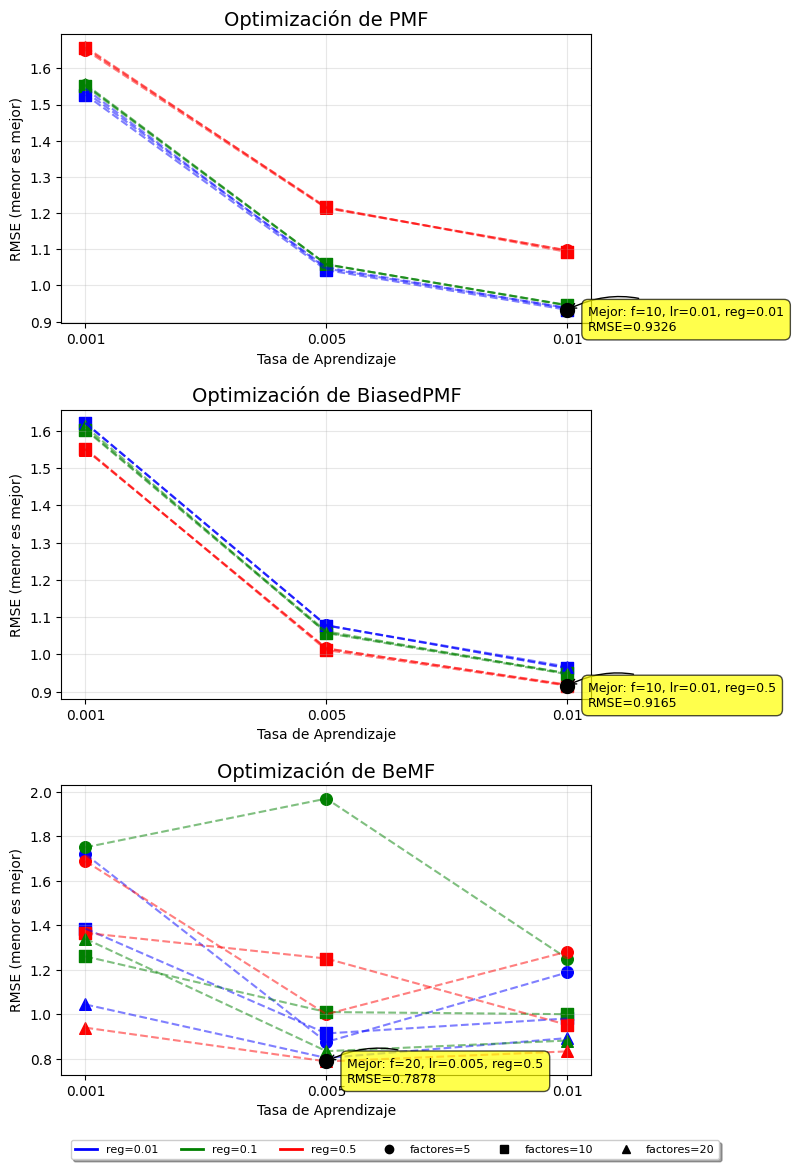

In [ ]:
def visualizar_optimizacion_parametros(todos_resultados):
    """Genera visualizaciones para los resultados de optimización de hiperparámetros"""
    fig, axes = plt.subplots(3, 1, figsize=(8, 12))
    
    # Configuración común para los gráficos
    modelos = ['PMF', 'BiasedPMF', 'BeMF']
    colores = {'0.01': 'blue', '0.1': 'green', '0.5': 'red'}
    markers = {'5': 'o', '10': 's', '20': '^'}
    
    for idx, modelo in enumerate(modelos):
        ax = axes[idx]
        resultados = todos_resultados[modelo]
        for res in resultados:
            factores = str(res['factores'])
            lr = str(res['lr'])
            reg = str(res['reg'])
            
            ax.scatter(lr, res['rmse'], color=colores[reg], marker=markers[factores], 
                      s=70, label=f"reg={reg}, f={factores}")
        
        for reg in ['0.01', '0.1', '0.5']:
            for f in ['5', '10', '20']:
                puntos = [(str(r['lr']), r['rmse']) for r in resultados 
                         if str(r['reg']) == reg and str(r['factores']) == f]
                if puntos:
                    x = [p[0] for p in puntos]
                    y = [p[1] for p in puntos]
                    ax.plot(x, y, color=colores[reg], linestyle='--', alpha=0.5)
        
        # Ajustamos los tamaños de fuente
        ax.set_title(f'Optimización de {modelo}', fontsize=14)
        ax.set_xlabel('Tasa de Aprendizaje', fontsize=10)
        ax.set_ylabel('RMSE (menor es mejor)', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Reducimos el tamaño del punto destacado y ajustamos la anotación
        mejor = min(resultados, key=lambda x: x['rmse'])
        ax.scatter(str(mejor['lr']), mejor['rmse'], color='black', s=100, zorder=10)
        ax.annotate(f"Mejor: f={mejor['factores']}, lr={mejor['lr']}, reg={mejor['reg']}\nRMSE={mejor['rmse']:.4f}",
                   (str(mejor['lr']), mejor['rmse']), 
                   xytext=(15, -15), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3'),
                   fontsize=9)
    
    # Crear una leyenda única para todos los gráficos (más pequeña)
    handles, labels = [], []
    for reg, color in colores.items():
        handles.append(plt.Line2D([0], [0], color=color, lw=2, label=f'reg={reg}'))
    
    for f, marker in markers.items():
        handles.append(plt.Line2D([0], [0], marker=marker, color='black', 
                                 markersize=6, label=f'factores={f}', linestyle='None'))
    
    fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 0.05), 
              ncol=6, fancybox=True, shadow=True, fontsize=8)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1, hspace=0.3)
    plt.savefig('optimizacion_parametros.png', dpi=300, bbox_inches='tight')
    plt.show()
# Ejecutar la visualización
visualizar_optimizacion_parametros(todos_resultados)

## Implementación de modelo base (media)

Ahora vamos a implementar un modelo base (media) para comparalo con los modelos de factorización matricial. Este modelo simplemente predice la media de las valoraciones para cada usuario o ítem, y se utiliza como referencia para evaluar el rendimiento de los modelos más complejos.:

In [66]:
def generar_predicciones_media_global(test_indices, train_matrix):
    """Genera predicciones usando la media global de ratings"""
    media_global = calculate_global_mean(train_matrix)
    predicciones = {}
    
    for u, i in test_indices:
        if u not in predicciones:
            predicciones[u] = {}
        predicciones[u][i] = media_global
    
    return predicciones



## Función de evaluación comparativa

Ahora, una función para evaluar y comparar todos los modelos:



In [84]:
def evaluar_todos_modelos(train_matrix, test_matrix, test_indices, mejores_params):
    """Evalúa todos los modelos usando los parámetros optimizados"""
    resultados = {}
    
    print("Evaluando modelo de media global...")
    pred_global = generar_predicciones_media_global(test_indices, train_matrix)
    resultados['Media Global'] = evaluate_matrix_factorization(pred_global, test_matrix)
    
    # PMF con parámetros optimizados
    params = mejores_params['PMF']['params']
    print(f"\nEvaluando PMF con parámetros optimizados: {params}")
    p, q = train_pmf(
        train_matrix, 
        num_iterations=10,
        learning_rate=params['lr'], 
        reg_param=params['reg'], 
        num_factors=params['factores']
    )
    pred_pmf = generate_pmf_predictions(test_indices, p, q)
    resultados['PMF Optimizado'] = evaluate_matrix_factorization(pred_pmf, test_matrix)
    
    # BiasedPMF con parámetros optimizados
    params = mejores_params['BiasedPMF']['params']
    print(f"\nEvaluando BiasedPMF con parámetros optimizados: {params}")
    avg, bu, bi, p_biased, q_biased = train_biased_pmf(
        train_matrix, 
        num_iterations=10,
        learning_rate=params['lr'], 
        reg_param=params['reg'], 
        num_factors=params['factores']
    )
    pred_biased = generate_biased_pmf_predictions(test_indices, avg, bu, bi, p_biased, q_biased)
    resultados['BiasedPMF Optimizado'] = evaluate_matrix_factorization(pred_biased, test_matrix)
    
    # BeMF con parámetros optimizados
    params = mejores_params['BeMF']['params']
    print(f"\nEvaluando BeMF con parámetros optimizados: {params}")
    
    # Cambiar temporalmente el número de factores para BeMF
    global NUM_FACTORS_BEMF
    temp_factors = NUM_FACTORS_BEMF
    NUM_FACTORS_BEMF = params['factores']
    
    u_factors, v_factors = train_bemf(
        train_matrix, 
        num_iterations=10,
        learning_rate=params['lr'], 
        reg_param=params['reg']
    )
    
    # Restaurar valor original
    NUM_FACTORS_BEMF = temp_factors
    
    pred_bemf = generate_bemf_predictions(test_indices, u_factors, v_factors)
    resultados['BeMF Optimizado'] = evaluate_matrix_factorization(pred_bemf, test_matrix)
    
    return resultados



## Visualización de resultados



In [68]:
def visualizar_resultados(resultados):
    """Visualiza los resultados de los diferentes modelos"""
    modelos = list(resultados.keys())
    
    # Extraer métricas
    rmse = [resultados[m]['rmse'] for m in modelos]
    mae = [resultados[m]['mae'] for m in modelos]
    precision = [resultados[m]['precision'] for m in modelos]
    recall = [resultados[m]['recall'] for m in modelos]
    f1 = [resultados[m]['f1'] for m in modelos]
    ndcg = [resultados[m]['ndcg'] for m in modelos]
    
    # Crear subplots
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    
    # RMSE
    axs[0, 0].bar(modelos, rmse, color='skyblue')
    axs[0, 0].set_title('RMSE (menor es mejor)')
    axs[0, 0].set_xticklabels(modelos, rotation=45, ha='right')
    
    # MAE
    axs[0, 1].bar(modelos, mae, color='lightgreen')
    axs[0, 1].set_title('MAE (menor es mejor)')
    axs[0, 1].set_xticklabels(modelos, rotation=45, ha='right')
    
    # Precision
    axs[0, 2].bar(modelos, precision, color='salmon')
    axs[0, 2].set_title('Precisión (mayor es mejor)')
    axs[0, 2].set_xticklabels(modelos, rotation=45, ha='right')
    
    # Recall
    axs[1, 0].bar(modelos, recall, color='lightpink')
    axs[1, 0].set_title('Recall (mayor es mejor)')
    axs[1, 0].set_xticklabels(modelos, rotation=45, ha='right')
    
    # F1
    axs[1, 1].bar(modelos, f1, color='khaki')
    axs[1, 1].set_title('F1 (mayor es mejor)')
    axs[1, 1].set_xticklabels(modelos, rotation=45, ha='right')
    
    # nDCG
    axs[1, 2].bar(modelos, ndcg, color='plum')
    axs[1, 2].set_title('nDCG (mayor es mejor)')
    axs[1, 2].set_xticklabels(modelos, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Tabla comparativa
    print("\nComparativa de modelos:")
    tabla = pd.DataFrame({
        'RMSE': rmse,
        'MAE': mae,
        'Precisión': precision,
        'Recall': recall,
        'F1': f1,
        'nDCG': ndcg
    }, index=modelos)
    
    return tabla

## Resultados

Optimizando hiperparámetros...

Optimizando PMF:
  Probando: factores=5, lr=0.001, reg=0.01
Entrenando modelo PMF...
Iteración 1/5


Iteración 2/5
Iteración 3/5
Iteración 4/5
Iteración 5/5
  Probando: factores=5, lr=0.001, reg=0.1
Entrenando modelo PMF...
Iteración 1/5
Iteración 2/5
Iteración 3/5
Iteración 4/5
Iteración 5/5
  Probando: factores=5, lr=0.001, reg=0.5
Entrenando modelo PMF...
Iteración 1/5
Iteración 2/5
Iteración 3/5
Iteración 4/5
Iteración 5/5
  Probando: factores=5, lr=0.005, reg=0.01
Entrenando modelo PMF...
Iteración 1/5
Iteración 2/5
Iteración 3/5
Iteración 4/5
Iteración 5/5
  Probando: factores=5, lr=0.005, reg=0.1
Entrenando modelo PMF...
Iteración 1/5
Iteración 2/5
Iteración 3/5
Iteración 4/5
Iteración 5/5
  Probando: factores=5, lr=0.005, reg=0.5
Entrenando modelo PMF...
Iteración 1/5
Iteración 2/5
Iteración 3/5
Iteración 4/5
Iteración 5/5
  Probando: factores=5, lr=0.01, reg=0.01
Entrenando modelo PMF...
Iteración 1/5
Iteración 2/5
Iteración 3/5
Iteración 4/5
Iteración 5/5
  Probando: factores=5, lr=0.01, reg=0.1
Entrenando modelo PMF...
Iteración 1/5
Iteración 2/5
Iteración 3/5
Iteración 4/5

C:\Users\brian\AppData\Local\Temp\ipykernel_14896\1761440322.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 0].set_xticklabels(modelos, rotation=45, ha='right')
C:\Users\brian\AppData\Local\Temp\ipykernel_14896\1761440322.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 1].set_xticklabels(modelos, rotation=45, ha='right')
C:\Users\brian\AppData\Local\Temp\ipykernel_14896\1761440322.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 2].set_xticklabels(modelos, rotation=45, ha='right')
C:\Users\brian\AppData\Local\Temp\ipykernel_14896\1761440322.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_xticklabels(mo

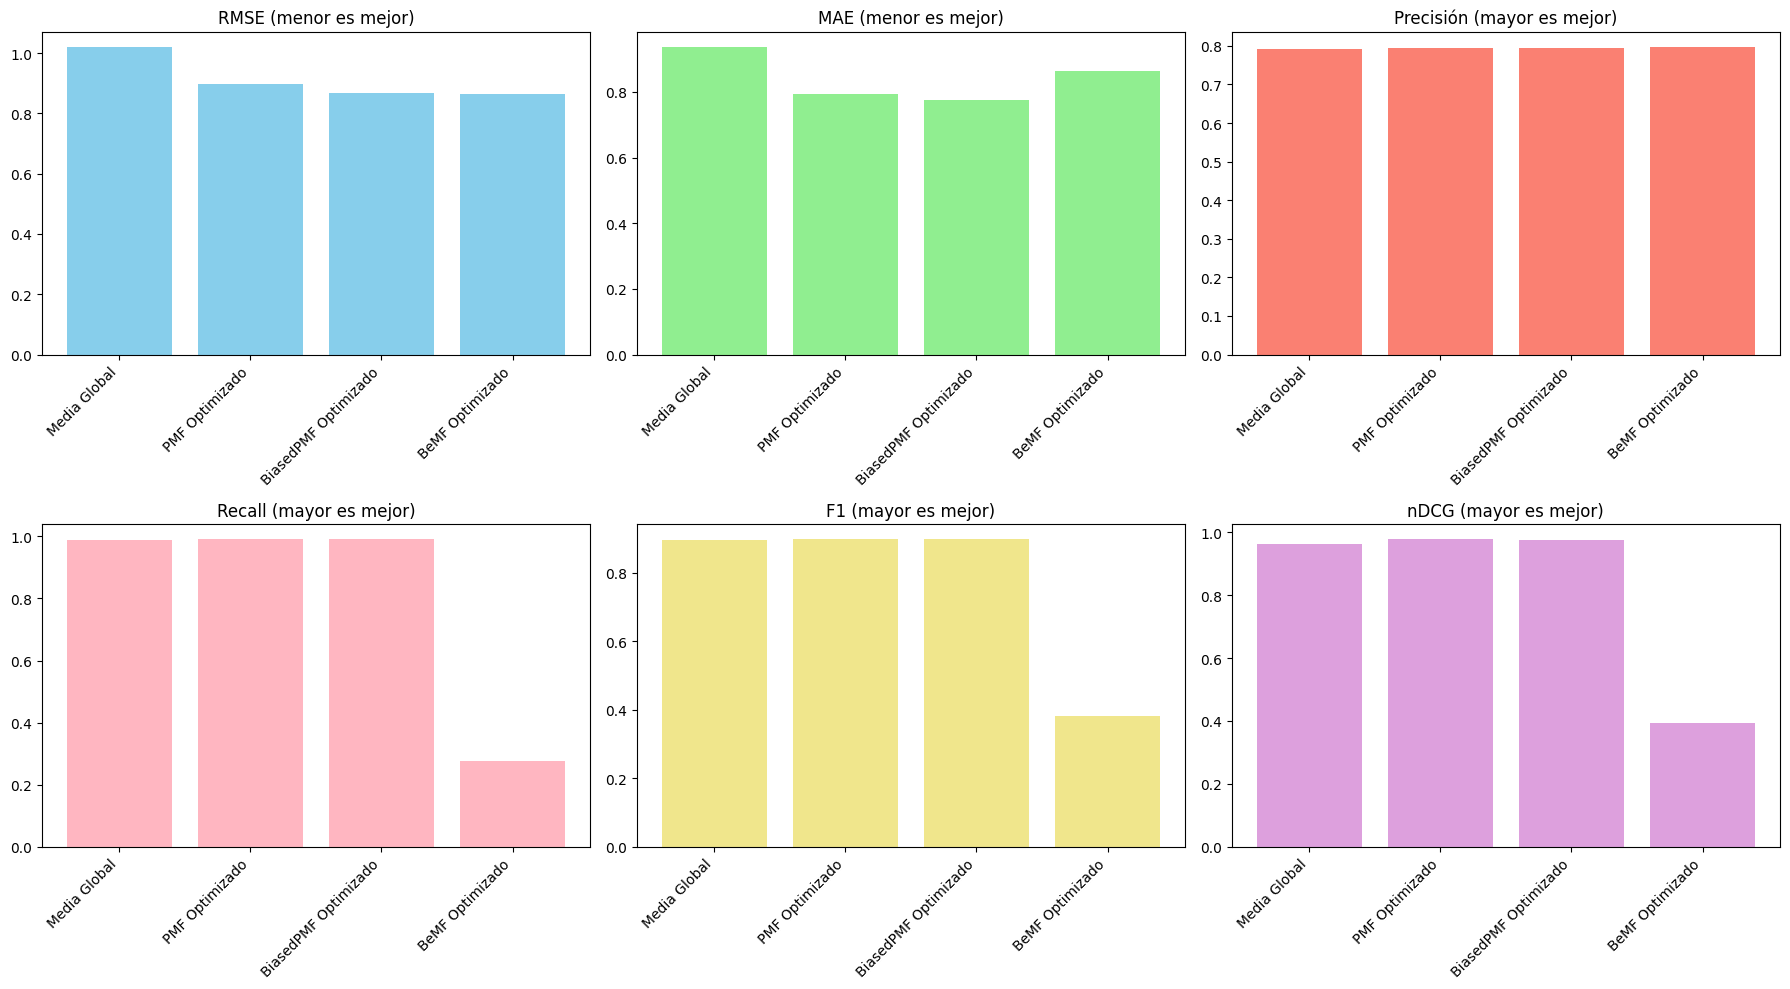


Comparativa de modelos:
                          RMSE       MAE  Precisión    Recall        F1  \
Media Global          1.019728  0.935929   0.792357  0.988899  0.896564   
PMF Optimizado        0.896244  0.792401   0.793244  0.989960  0.897468   
BiasedPMF Optimizado  0.867176  0.774358   0.793402  0.989906  0.897550   
BeMF Optimizado       0.863835  0.862403   0.796512  0.277132  0.382479   

                          nDCG  
Media Global          0.962687  
PMF Optimizado        0.977367  
BiasedPMF Optimizado  0.975715  
BeMF Optimizado       0.393804  


In [ ]:
# Obtener índices de prueba
test_indices = list(zip(*test_matrix.nonzero()))

# Utilizamos los parámetros obtenidos de la optimización
mejores_params = {
    'PMF': {
        'rmse': 0.9326,
        'params': {'factores': 10, 'lr': 0.01, 'reg': 0.01}
    },
    'BiasedPMF': {
        'rmse': 0.9165,
        'params': {'factores': 10, 'lr': 0.01, 'reg': 0.5}
    },
    'BeMF': {
        'rmse': 0.7878,
        'params': {'factores': 20, 'lr': 0.005, 'reg': 0.5}
    }
}

# Usar los parámetros óptimos preestablecidos
resultados = evaluar_todos_modelos(train_matrix, test_matrix, test_indices, mejores_params)

# Visualizar y analizar resultados
tabla_comparativa = visualizar_resultados(resultados)
print(tabla_comparativa)

## Análisis de resultados

In [85]:
def analizar_resultados(resultados):
    """Genera un análisis textual de los resultados"""
    modelos = list(resultados.keys())
    
    # Encontrar mejor modelo según RMSE
    mejor_rmse = min(modelos, key=lambda m: resultados[m]['rmse'])
    peor_rmse = max(modelos, key=lambda m: resultados[m]['rmse'])
    
    # Encontrar mejor modelo según Precisión
    mejor_precision = max(modelos, key=lambda m: resultados[m]['precision'])
    
    # Encontrar mejor modelo según F1
    mejor_f1 = max(modelos, key=lambda m: resultados[m]['f1'])
    
    # Encontrar mejor modelo según nDCG
    mejor_ndcg = max(modelos, key=lambda m: resultados[m]['ndcg'])
    
    # Calcular mejora sobre línea base
    if 'Media Global' in resultados:
        base_rmse = resultados['Media Global']['rmse']
        mejoras_rmse = {m: (1 - resultados[m]['rmse']/base_rmse)*100 for m in modelos if m != 'Media Global'}
        mejor_mejora = max(mejoras_rmse.items(), key=lambda x: x[1])
    
    print("\nANÁLISIS DE RESULTADOS")
    print("=====================")
    print(f"Mejor modelo según RMSE: {mejor_rmse} con {resultados[mejor_rmse]['rmse']:.4f}")
    print(f"Peor modelo según RMSE: {peor_rmse} con {resultados[peor_rmse]['rmse']:.4f}")
    print(f"Mejor modelo según Precisión: {mejor_precision} con {resultados[mejor_precision]['precision']:.4f}")
    print(f"Mejor modelo según F1: {mejor_f1} con {resultados[mejor_f1]['f1']:.4f}")
    print(f"Mejor modelo según nDCG: {mejor_ndcg} con {resultados[mejor_ndcg]['ndcg']:.4f}")
    
    if 'Media Global' in resultados:
        print(f"\nMejora sobre línea base (Media Global):")
        for m, mejora in sorted(mejoras_rmse.items(), key=lambda x: x[1], reverse=True):
            print(f"  {m}: {mejora:.2f}% de mejora en RMSE")
            

In [86]:
analizar_resultados(resultados)


ANÁLISIS DE RESULTADOS
Mejor modelo según RMSE: BeMF Optimizado con 0.8638
Peor modelo según RMSE: Media Global con 1.0197
Mejor modelo según Precisión: BeMF Optimizado con 0.7965
Mejor modelo según F1: BiasedPMF Optimizado con 0.8975
Mejor modelo según nDCG: PMF Optimizado con 0.9774

Mejora sobre línea base (Media Global):
  BeMF Optimizado: 15.29% de mejora en RMSE
  BiasedPMF Optimizado: 14.96% de mejora en RMSE
  PMF Optimizado: 12.11% de mejora en RMSE
